In [55]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Reading in original data

In [56]:
og_train_df = pd.read_csv('train.csv')
og_test_df = pd.read_csv('test.csv')

og_train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [57]:
og_test_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


In [58]:
meal_df = pd.read_csv('meal_info.csv')
meal_df.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [59]:
center_df = pd.read_csv('fulfilment_center_info.csv')
center_df.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


## Merging data to create new data sets

In [60]:
new_train_df = pd.merge(og_train_df,meal_df,on='meal_id',how='inner')
new_train_df = pd.merge(new_train_df,center_df,on='center_id',how='inner')
print("Shape of new train dataframe:",new_train_df.shape)
print("Missing values in new train dataframe:\n",new_train_df.isnull().sum())
new_train_df.head()

Shape of new train dataframe: (456548, 15)
Missing values in new train dataframe:
 id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
num_orders               0
category                 0
cuisine                  0
city_code                0
region_code              0
center_type              0
op_area                  0
dtype: int64


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1,1018704,2,55,1885,135.83,152.29,0,0,323,Beverages,Thai,647,56,TYPE_C,2.0
2,1196273,3,55,1885,132.92,133.92,0,0,96,Beverages,Thai,647,56,TYPE_C,2.0
3,1116527,4,55,1885,135.86,134.86,0,0,163,Beverages,Thai,647,56,TYPE_C,2.0
4,1343872,5,55,1885,146.50,147.50,0,0,215,Beverages,Thai,647,56,TYPE_C,2.0


In [61]:
new_test_df = pd.merge(og_test_df,meal_df,on='meal_id',how='inner')
new_test_df = pd.merge(new_test_df,center_df,on='center_id',how='inner')
print("Shape of new train dataframe:",new_test_df.shape)
print("Missing values in new test dataframe:\n",new_test_df.isnull().sum())
new_test_df.head()

Shape of new train dataframe: (32573, 14)
Missing values in new test dataframe:
 id                       0
week                     0
center_id                0
meal_id                  0
checkout_price           0
base_price               0
emailer_for_promotion    0
homepage_featured        0
category                 0
cuisine                  0
city_code                0
region_code              0
center_type              0
op_area                  0
dtype: int64


,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,category,cuisine,city_code,region_code,center_type,op_area
0,1028232,146,55,1885,158.11,159.11,0,0,Beverages,Thai,647,56,TYPE_C,2.0
1,1262649,147,55,1885,159.11,159.11,0,0,Beverages,Thai,647,56,TYPE_C,2.0
2,1453211,149,55,1885,157.14,158.14,0,0,Beverages,Thai,647,56,TYPE_C,2.0
3,1262599,150,55,1885,159.14,157.14,0,0,Beverages,Thai,647,56,TYPE_C,2.0
4,1495848,151,55,1885,160.11,159.11,0,0,Beverages,Thai,647,56,TYPE_C,2.0


In [62]:
new_train_df.drop('num_orders',axis=1).columns == new_test_df.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

So, both the dataframe structures are similar for train and test.

### Creating a lagged demand feature

In [63]:
# Storing the average of demands for every food item in every center (for imputation purpose incase past week data does not exist)

grouped = new_train_df.groupby(['center_id','meal_id'])['num_orders'].mean()
grouped = grouped.reset_index()
grouped = grouped.rename({'num_orders':'avg_orders'},axis=1)
grouped.head()

,center_id,meal_id,avg_orders
0,10,1062,949.944828
1,10,1109,1528.862069
2,10,1198,347.537931
3,10,1207,215.493056
4,10,1216,146.433566


In [64]:
# Performing a left join on train set to find lagged orders demand
new_train_df['prev_week'] = new_train_df['week'].map(lambda x:x+1)
new_train_df_1 = new_train_df.merge(new_train_df,how='left', left_on=['week', 'center_id', 'meal_id'], right_on=['prev_week', 'center_id', 'meal_id'])
new_train_df_1.columns

Index(['id_x', 'week_x', 'center_id', 'meal_id', 'checkout_price_x',
       'base_price_x', 'emailer_for_promotion_x', 'homepage_featured_x',
       'num_orders_x', 'category_x', 'cuisine_x', 'city_code_x',
       'region_code_x', 'center_type_x', 'op_area_x', 'prev_week_x', 'id_y',
       'week_y', 'checkout_price_y', 'base_price_y', 'emailer_for_promotion_y',
       'homepage_featured_y', 'num_orders_y', 'category_y', 'cuisine_y',
       'city_code_y', 'region_code_y', 'center_type_y', 'op_area_y',
       'prev_week_y'],
      dtype='object')

In [65]:
new_train_df_1 = new_train_df_1[['id_x', 'week_x', 'center_id', 'meal_id', 'checkout_price_x',
       'base_price_x', 'emailer_for_promotion_x', 'homepage_featured_x',
       'num_orders_x', 'category_x', 'cuisine_x', 'city_code_x',
       'region_code_x', 'center_type_x', 'op_area_x', 'prev_week_x','num_orders_y']]

new_train_df_1 = new_train_df_1.rename({'id_x':'id', 'week_x':'week', 'checkout_price_x':'checkout_price',
       'base_price_x':'base_price', 'emailer_for_promotion_x':'emailer_for_promotion', 'homepage_featured_x':'homepage_featured',
       'num_orders_x':'num_orders', 'category_x':'category', 'cuisine_x':'cuisine', 'city_code_x':'city_code',
       'region_code_x':'region_code', 'center_type_x':'center_type', 'op_area_x':'op_area','num_orders_y':'lagged_num_orders'},axis=1)

new_train_df_1 = new_train_df_1.drop('prev_week_x',axis=1)

new_train_df = new_train_df_1
new_train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area,lagged_num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0,NaN
1,1018704,2,55,1885,135.83,152.29,0,0,323,Beverages,Thai,647,56,TYPE_C,2.0,177.0
2,1196273,3,55,1885,132.92,133.92,0,0,96,Beverages,Thai,647,56,TYPE_C,2.0,323.0
3,1116527,4,55,1885,135.86,134.86,0,0,163,Beverages,Thai,647,56,TYPE_C,2.0,96.0
4,1343872,5,55,1885,146.50,147.50,0,0,215,Beverages,Thai,647,56,TYPE_C,2.0,163.0


Clearly, there are some NaN values (as for the first week, there will be no lagged demand data). Let us now impute this with the average demand for those meals at those particular centers

In [66]:
new_train_df_1 = new_train_df.merge(grouped,how='inner',on=['center_id','meal_id'])
new_train_df_1['lagged_num_orders'] = new_train_df_1['lagged_num_orders'].fillna(new_train_df_1['avg_orders'])
new_train_df_1 = new_train_df_1.drop('avg_orders',axis=1)
new_train_df = new_train_df_1
new_train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area,lagged_num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0,230.324138
1,1018704,2,55,1885,135.83,152.29,0,0,323,Beverages,Thai,647,56,TYPE_C,2.0,177.000000
2,1196273,3,55,1885,132.92,133.92,0,0,96,Beverages,Thai,647,56,TYPE_C,2.0,323.000000
3,1116527,4,55,1885,135.86,134.86,0,0,163,Beverages,Thai,647,56,TYPE_C,2.0,96.000000
4,1343872,5,55,1885,146.50,147.50,0,0,215,Beverages,Thai,647,56,TYPE_C,2.0,163.000000


## EDA:

Exploratory Data Analysis conducted on the new merged train data set

<AxesSubplot:ylabel='num_orders'>

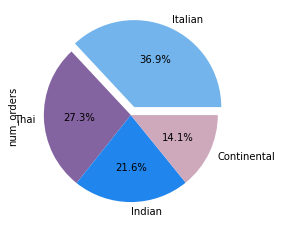

In [67]:
# Displaying the cuisines with most orders
new_train_df.groupby('cuisine')['num_orders'].sum().sort_values(ascending=False).plot.pie(explode=(0.1,0,0,0),colors=['#72b4eb','#8464a0','#2085ec','#cea9bc',],autopct='%1.1f%%')

<AxesSubplot:title={'center':'Most Popular Category of Orders'}, xlabel='category'>

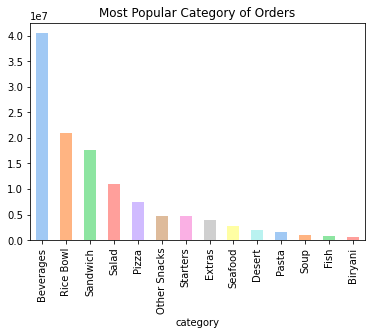

In [68]:
# Displaying the most popular category of orders
new_train_df.groupby('category')['num_orders'].sum().sort_values(ascending=False).plot(kind='bar',color=sns.color_palette('pastel'),title='Most Popular Category of Orders')

In [69]:
# Displaying centers with top 10 average checkout price per order
print("Centers with top 10 average checkout price per order:")
new_train_df.groupby('center_id')['checkout_price'].mean().sort_values(ascending=False)[:10]

Centers with top 10 average checkout price per order:


center_id
34     347.856483
68     345.429941
65     345.176067
83     344.908958
143    344.764757
66     344.476706
32     344.177420
75     343.902557
50     343.836486
146    343.820432
Name: checkout_price, dtype: float64

In [70]:
# cross checking values
new_train_df.loc[new_train_df['center_id']==10,'checkout_price'].mean()

335.61569208838137

<AxesSubplot:title={'center':'Displaying top 10 (city code, region code) for number of orders'}, ylabel='city_code,region_code'>

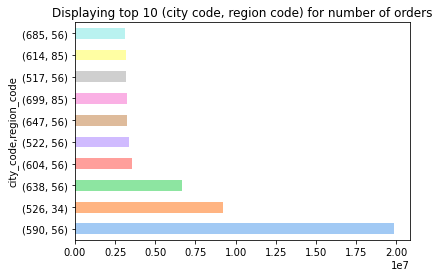

In [71]:
new_train_df.groupby(['city_code','region_code'])['num_orders'].sum().sort_values(ascending=False)[:10].plot(kind='barh',color=sns.color_palette('pastel'),title='Displaying top 10 (city code, region code) for number of orders')

### Basic Preprocessing

In [77]:
new_train_df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area,lagged_num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0,230.324138
1,1018704,2,55,1885,135.83,152.29,0,0,323,Beverages,Thai,647,56,TYPE_C,2.0,177.000000
2,1196273,3,55,1885,132.92,133.92,0,0,96,Beverages,Thai,647,56,TYPE_C,2.0,323.000000
3,1116527,4,55,1885,135.86,134.86,0,0,163,Beverages,Thai,647,56,TYPE_C,2.0,96.000000
4,1343872,5,55,1885,146.50,147.50,0,0,215,Beverages,Thai,647,56,TYPE_C,2.0,163.000000


In [78]:
new_train_df.columns

Index(['id', 'week', 'center_id', 'meal_id', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'category',
       'cuisine', 'city_code', 'region_code', 'center_type', 'op_area',
       'lagged_num_orders'],
      dtype='object')

In [79]:
df1=new_train_df[['week', 'checkout_price', 'base_price',
       'emailer_for_promotion', 'homepage_featured', 'num_orders', 'category',
       'cuisine', 'city_code', 'region_code','center_type', 'op_area','lagged_num_orders']] #removing unnecessary columns
df1.head()

,week,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area,lagged_num_orders
0,1,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0,230.324138
1,2,135.83,152.29,0,0,323,Beverages,Thai,647,56,TYPE_C,2.0,177.000000
2,3,132.92,133.92,0,0,96,Beverages,Thai,647,56,TYPE_C,2.0,323.000000
3,4,135.86,134.86,0,0,163,Beverages,Thai,647,56,TYPE_C,2.0,96.000000
4,5,146.50,147.50,0,0,215,Beverages,Thai,647,56,TYPE_C,2.0,163.000000


In [112]:
#Splitting into X and y
y = df1['num_orders']
X = df1.drop('num_orders',axis=1)

from sklearn.model_selection import train_test_split,GridSearchCV

#Splitting into train and validation sets
X_train,X_validation,y_train,y_validation = train_test_split(X,y,test_size=0.2)

In [113]:
X_train.head()

,week,checkout_price,base_price,emailer_for_promotion,homepage_featured,category,cuisine,city_code,region_code,center_type,op_area,lagged_num_orders
241728,89,157.20,179.45,0,0,Beverages,Italian,658,34,TYPE_B,3.9,109.000000
64836,140,726.53,726.53,0,0,Seafood,Continental,526,34,TYPE_B,5.0,99.588652
154382,95,151.35,151.35,0,0,Beverages,Indian,526,34,TYPE_C,2.9,134.000000
156256,86,310.43,309.43,0,0,Sandwich,Italian,526,34,TYPE_C,2.9,80.000000
144923,40,292.03,291.03,0,0,Other Snacks,Thai,615,34,TYPE_B,4.2,175.000000


In [114]:
X_train.columns

Index(['week', 'checkout_price', 'base_price', 'emailer_for_promotion',
       'homepage_featured', 'category', 'cuisine', 'city_code', 'region_code',
       'center_type', 'op_area', 'lagged_num_orders'],
      dtype='object')

In [115]:
num_cols = ['week', 'checkout_price', 'base_price', 'op_area','lagged_num_orders']
cat_cols = ['emailer_for_promotion','homepage_featured', 'category', 'cuisine', 'city_code', 'region_code','center_type']

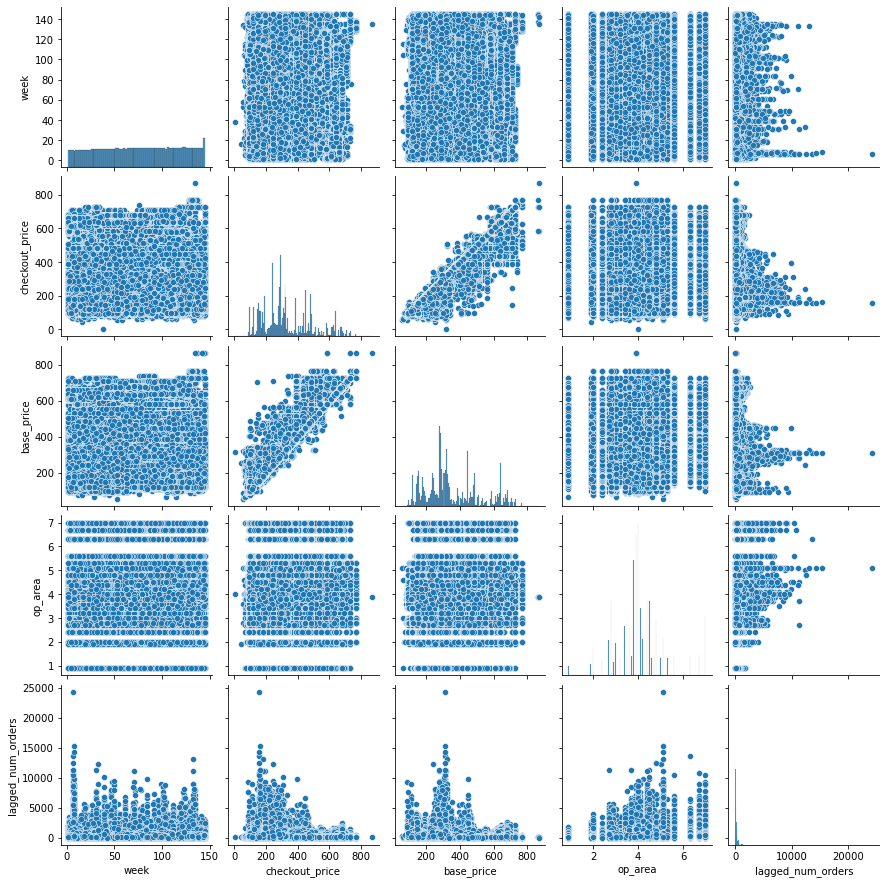

In [116]:
sns.pairplot(X_train[num_cols])

<AxesSubplot:>

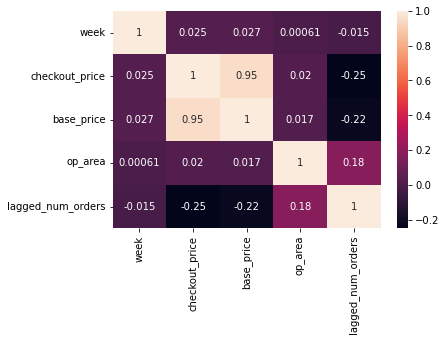

In [117]:
sns.heatmap(X_train[num_cols].corr(),annot=True)

Clearly, checkout_price is very highly correlated with base_price. We can drop this without much loss of information.

In [118]:
X_train = X_train.drop('checkout_price',axis=1)
X_validation = X_validation.drop('checkout_price',axis=1)

X_train.head()

,week,base_price,emailer_for_promotion,homepage_featured,category,cuisine,city_code,region_code,center_type,op_area,lagged_num_orders
241728,89,179.45,0,0,Beverages,Italian,658,34,TYPE_B,3.9,109.000000
64836,140,726.53,0,0,Seafood,Continental,526,34,TYPE_B,5.0,99.588652
154382,95,151.35,0,0,Beverages,Indian,526,34,TYPE_C,2.9,134.000000
156256,86,309.43,0,0,Sandwich,Italian,526,34,TYPE_C,2.9,80.000000
144923,40,291.03,0,0,Other Snacks,Thai,615,34,TYPE_B,4.2,175.000000


### Standard Scaling on Numeric Columns

In [119]:
#Performing standard scaling
from sklearn.preprocessing import StandardScaler

scale_cols = ['base_price','op_area','lagged_num_orders']

scaler = StandardScaler()
scaler.fit(X_train[scale_cols])
X_train[scale_cols] = scaler.transform(X_train[scale_cols])
X_validation[scale_cols] = scaler.transform(X_validation[scale_cols])    

<AxesSubplot:xlabel='lagged_num_orders', ylabel='Density'>

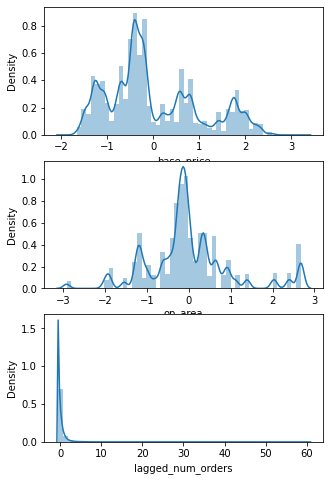

In [120]:
fig, axes = plt.subplots(3, 1, figsize=(5, 8))

sns.distplot(X_train['base_price'],ax=axes[0])
sns.distplot(X_train['op_area'],ax=axes[1])
sns.distplot(X_train['lagged_num_orders'],ax=axes[2])

There does not seem to be any concerning outliers/behavior. The lagged orders is highly right skewed. We could try doing a log transformation to make it look more normally distributed. But let us try initially without transforming.

### One-Hot Encoding of Numeric Variables

In [121]:
# Example train and test datasets
#train = pd.DataFrame({'A': ['red', 'blue', 'green', 'red'], 'B': [1, 2, 3, 4]})
#test = pd.DataFrame({'A': ['blue', 'green', 'yellow'], 'B': [5, 6, 7]})

cat_columns = ['emailer_for_promotion', 'homepage_featured', 'category', 'cuisine', 'city_code', 'region_code', 'center_type']

# Perform One-Hot Encoding on train set
train_encoded = pd.get_dummies(X_train, columns=cat_columns, drop_first=True)

# Perform One-Hot Encoding on test set with same columns as train set
test_encoded = pd.get_dummies(X_validation, columns=cat_columns, drop_first=True)

# Add missing columns from train set to test set with default values
missing_cols = set(train_encoded.columns) - set(test_encoded.columns)
for col in missing_cols:
    test_encoded[col] = 0

# Reorder columns in test set to match train set
test_encoded = test_encoded[train_encoded.columns]

X_train = train_encoded
X_validation = test_encoded

X_train.head()

,week,base_price,op_area,lagged_num_orders,emailer_for_promotion_1,homepage_featured_1,category_Biryani,category_Desert,category_Extras,category_Fish,...,city_code_713,region_code_34,region_code_35,region_code_56,region_code_71,region_code_77,region_code_85,region_code_93,center_type_TYPE_B,center_type_TYPE_C
241728,89,-1.087301,-0.168453,-0.387912,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
64836,140,2.317423,0.840312,-0.411693,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
154382,95,-1.262180,-1.085512,-0.324740,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
156256,86,-0.278377,-1.085512,-0.461191,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
144923,40,-0.392889,0.106665,-0.221138,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


### Linear Regression Model with Lagged Demand Feature

In [93]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_validation)

In [94]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_validation, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_validation, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = mse**0.5

# Calculate R-squared (R2) score
r2 = r2_score(y_validation, y_pred)

# Print the calculated metrics
print("Mean Absolute Error (MAE) on Validation Set:", mae)
print("Mean Squared Error (MSE) on Validation Set:", mse)
print("Root Mean Squared Error (RMSE) on Validation Set:", rmse)
print("R-squared (R2) score on Validation Set:", r2)

Mean Absolute Error (MAE) on Validation Set: 119.45223126610404
Mean Squared Error (MSE) on Validation Set: 68735.25233347336
Root Mean Squared Error (RMSE) on Validation Set: 262.1740878375919
R-squared (R2) score on Validation Set: 0.5790861975495452


### Hyperparamter Tuning for Linear Regression (Lidge and Rasso Penalties) for Lagged Demand Model

In [95]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso

# Specify the hyperparameter tuning grid for Ridge regression
ridge_param_grid = {
    'alpha': [0.01, 0.1, 1.0],
    'fit_intercept': [True, False],
}

# Specify the hyperparameter tuning grid for Lasso regression
lasso_param_grid = {
    'alpha': [0.01, 0.1, 1.0],
    'fit_intercept': [True, False],
}

# Create Ridge and Lasso regression models
ridge_model = Ridge()
lasso_model = Lasso()

# Perform hyperparameter tuning using GridSearchCV for Ridge regression
ridge_grid_search = GridSearchCV(ridge_model, ridge_param_grid, cv=5,verbose=10,n_jobs=-1)
ridge_grid_search.fit(X_train, y_train)

# Perform hyperparameter tuning using GridSearchCV for Lasso regression
lasso_grid_search = GridSearchCV(lasso_model, lasso_param_grid, cv=5,verbose=10,n_jobs=-1)
lasso_grid_search.fit(X_train, y_train)

# Print the best hyperparameters and best score for Ridge regression
print("Best Hyperparameters for Ridge Regression: ", ridge_grid_search.best_params_)
print("Best Score for Ridge Regression: ", ridge_grid_search.best_score_)

# Print the best hyperparameters and best score for Lasso regression
print("Best Hyperparameters for Lasso Regression: ", lasso_grid_search.best_params_)
print("Best Score for Lasso Regression: ", lasso_grid_search.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Hyperparameters for Ridge Regression:  {'alpha': 1.0, 'fit_intercept': False}
Best Score for Ridge Regression:  0.60316890706382
Best Hyperparameters for Lasso Regression:  {'alpha': 0.01, 'fit_intercept': True}
Best Score for Lasso Regression:  0.603167735389597


So the best model is a Ridge Regression Model with parameters {'alpha': 1.0, 'fit_intercept': False}. Let us now store this

In [96]:
best_lr_model = ridge_grid_search.best_estimator_

In [97]:
best_lr_model.fit(X_train,y_train)
y_pred = best_lr_model.predict(X_validation)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_validation, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_validation, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = mse**0.5

# Calculate R-squared (R2) score
r2 = r2_score(y_validation, y_pred)

# Print the calculated metrics
print("Mean Absolute Error (MAE) on Validation Set:", mae)
print("Mean Squared Error (MSE) on Validation Set:", mse)
print("Root Mean Squared Error (RMSE) on Validation Set:", rmse)
print("R-squared (R2) score on Validation Set:", r2)

Mean Absolute Error (MAE) on Validation Set: 119.4496939396587
Mean Squared Error (MSE) on Validation Set: 68735.29742785946
Root Mean Squared Error (RMSE) on Validation Set: 262.17417383842263
R-squared (R2) score on Validation Set: 0.5790859214052251


In [102]:
# Extract the coefficients and feature names
coefficients = best_lr_model.coef_
feature_names = X_train.columns

# Create a dataframe to store the coefficients and feature names
coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the coefficients by absolute value in descending order
coeff_df = coeff_df.reindex(coeff_df['Coefficient'].abs().sort_values(ascending=False).index)

# Display the dataframe
print("Top 10 largest Coefficients of the Best Ridge Regression Model:")
coeff_df.head(10)

Top 10 largest Coefficients of the Best Ridge Regression Model:


,Feature,Coefficient
4,emailer_for_promotion_1,288.389715
13,category_Rice Bowl,282.963768
66,city_code_698,216.257821
17,category_Soup,-215.689003
74,region_code_56,208.621999
3,lagged_num_orders,200.116932
77,region_code_85,171.995929
11,category_Pasta,-163.312933
76,region_code_77,159.156011
10,category_Other Snacks,-154.282305


So, lagged orders feature seems to have a big coefficient which suggests this is indeed an important feature